# AE3 - Exercicio 5B - POISSON e BURGERS

## Bloco 0 — Imports, device e utilitários

In [1]:
# === BLOCO 0 — Imports, device e utilitários ===
# (se precisar) !pip -q install torch matplotlib numpy scipy

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Bessel modificado para a solução analítica de Burgers (Basdevant)
try:
    from scipy.special import iv as besseli   # I_n(z)
    from scipy.special import i0 as besseli0  # I_0(z)
    HAVE_SCIPY = True
except Exception as e:
    HAVE_SCIPY = False
    print("⚠️ SciPy não encontrado. A solução analítica de Burgers requer I_n(z). Instale SciPy para comparar.")

# CPU-friendly
torch.set_num_threads(min(4, os.cpu_count() or 4))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# seeds
np.random.seed(0); torch.manual_seed(0)

# utilidades de autograd
def leaf(x_np):
    x = torch.tensor(x_np, dtype=torch.float32, device=device).view(-1,1)
    x.requires_grad_(True)
    return x

def d(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def d2(y, x):
    yx = d(y, x)
    return torch.autograd.grad(yx, x, grad_outputs=torch.ones_like(yx),
                               create_graph=True, retain_graph=True)[0]


Device: cpu


# Poisson 1D

## Bloco P1 — Problema, rede (Condições de contorno hard) e pontos de colocação

In [2]:
# === BLOCO P1 — Definição Poisson 1D ===
# PDE: u''(x) + π^2 sin(πx) = 0 em (-1,1); Dirichlet u(-1)=u(1)=0
# Solução analítica: u(x) = sin(π x)

pi = np.pi

# hiperparâmetros (equilíbrio entre leve e robusto)
EPOCHS_P   = 15000    # treino principal (Adam apenas)
LR_P       = 1e-3
Nf_P       = 600      # pontos de colocação no interior
ACT_P      = "tanh"
HID_P      = 3
NEU_P      = 32

# Rede: C.C. hard usando u(x) = (1 - x^2) * N(x)  -> u(±1)=0
def act(name): return {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU}[name]()

class MLP1D(nn.Module):
    def __init__(self, hidden, neurons, actname="tanh"):
        super().__init__()
        layers = [nn.Linear(1, neurons), act(actname)]
        for _ in range(hidden-1):
            layers += [nn.Linear(neurons, neurons), act(actname)]
        layers += [nn.Linear(neurons, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class PINN_Poisson(nn.Module):
    def __init__(self, hidden, neurons, actname="tanh"):
        super().__init__()
        self.core = MLP1D(hidden, neurons, actname)
    def forward(self, x):
        return (1 - x**2) * self.core(x)

netP = PINN_Poisson(HID_P, NEU_P, ACT_P).to(device)

# amostragem interior
x_f = leaf(np.random.uniform(-1, 1, size=Nf_P))


## Bloco P2 — Loss (resíduo) e treino Adam

In [3]:
# === BLOCO P2 — Loss e treino (Adam) para Poisson ===
mse = nn.MSELoss()
optP = torch.optim.Adam(netP.parameters(), lr=LR_P)
loss_hist_P = []

def residual_poisson(x):
    u = netP(x)
    u_xx = d2(u, x)
    f = - (pi**2) * torch.sin(pi * x)  # u'' = f => res = u_xx - f = 0  (ou u_xx + π^2 sin(πx) = 0)
    return u_xx - f

print(f"[Poisson] Adam: epochs={EPOCHS_P}, LR={LR_P}, Nf={Nf_P}, rede={HID_P}×{NEU_P} {ACT_P}")
for ep in range(1, EPOCHS_P+1):
    if ep % 200 == 1 and ep > 1:
        x_f = leaf(np.random.uniform(-1, 1, size=Nf_P))
    optP.zero_grad()
    r = residual_poisson(x_f)
    loss = mse(r, torch.zeros_like(r))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(netP.parameters(), 1.0)
    optP.step()
    loss_hist_P.append(float(loss.detach().cpu()))
    if ep % 1000 == 0:
        print(f"  ep {ep:5d} | loss={loss_hist_P[-1]:.3e}")


[Poisson] Adam: epochs=15000, LR=0.001, Nf=600, rede=3×32 tanh
  ep  1000 | loss=1.524e-04
  ep  2000 | loss=2.508e-05
  ep  3000 | loss=1.439e-05
  ep  4000 | loss=4.270e-04
  ep  5000 | loss=8.922e-06
  ep  6000 | loss=2.048e-05
  ep  7000 | loss=6.474e-06
  ep  8000 | loss=2.925e-06
  ep  9000 | loss=2.627e-06
  ep 10000 | loss=1.803e-06
  ep 11000 | loss=7.207e-06
  ep 12000 | loss=1.133e-06
  ep 13000 | loss=1.089e-06
  ep 14000 | loss=1.920e-06
  ep 15000 | loss=1.242e-06


## Bloco P3 — Pós-processamento: comparação Analítica × PINN e perda

[Poisson] Erro máximo % = 0.04%


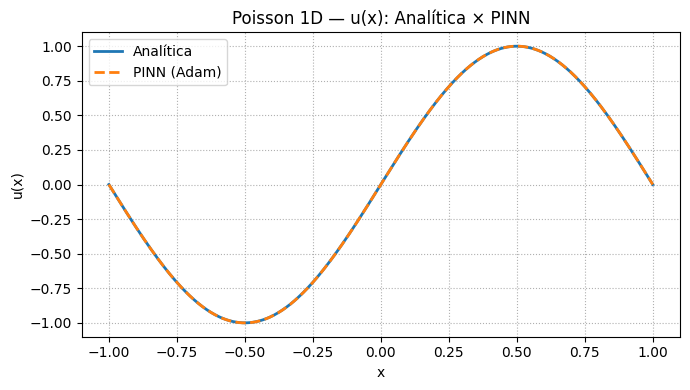

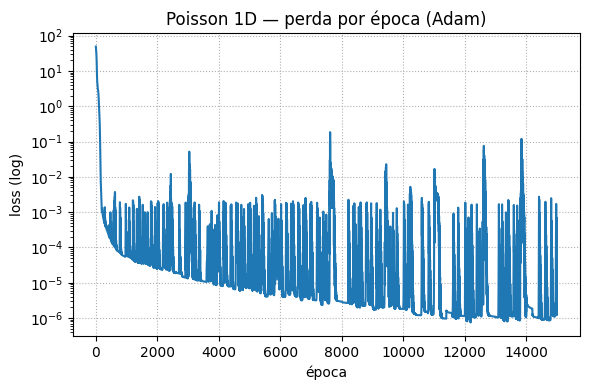

In [4]:
# === BLOCO P3 — Pós-processamento Poisson ===
# solução analítica
def uP_analytical(x): return np.sin(pi*x)

xg = np.linspace(-1, 1, 801)
xg_t = leaf(xg)

with torch.no_grad():
    u_pred = netP(xg_t).cpu().numpy().ravel()

u_ref = uP_analytical(xg)

def rel_max_pct(a, b):
    den = max(1e-12, np.max(np.abs(b)))
    return 100.0*np.max(np.abs(a-b))/den

print(f"[Poisson] Erro máximo % = {rel_max_pct(u_pred, u_ref):.2f}%")

# gráfico solução
plt.figure(figsize=(7,4))
plt.plot(xg, u_ref, label="Analítica", lw=2)
plt.plot(xg, u_pred, "--", label="PINN (Adam)", lw=2)
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title("Poisson 1D — u(x): Analítica × PINN")
plt.grid(True, ls=":"); plt.legend(); plt.tight_layout(); plt.show()

# gráfico perda
plt.figure(figsize=(6,4))
plt.plot(loss_hist_P, lw=1.5)
plt.yscale("log"); plt.grid(True, ls=":")
plt.xlabel("época"); plt.ylabel("loss (log)")
plt.title("Poisson 1D — perda por época (Adam)")
plt.tight_layout(); plt.show()


# Burgers 1D (viscosa)

## Bloco B1 — (modelo + treino) com gradiente seguro e “link” ao grafo

In [21]:
# === BLOCO B1 — Burgers 1D com BCs "soft" (treino Adam, derivadas seguras) ===
import numpy as np, torch, torch.nn as nn

# Reprodutibilidade
np.random.seed(0)
torch.manual_seed(0)

# Dispositivo e dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# Hiperparâmetros
EPOCHS_B   = 15000
LR_B       = 1e-3
Nf_B       = 6000     # interior (PDE)
N0_B       = 512      # pontos da condição inicial t=0
Nb_B       = 512      # pontos da fronteira x=±1
HID_B      = 4
NEU_B      = 48
ACT_B      = "tanh"
Tmax       = 1.0
beta       = 0.01/np.pi

# Pesos das parcelas de loss
w_pde, w_ic, w_bc = 1.0, 10.0, 10.0

# Constantes como tensores
PI_T   = torch.tensor(np.pi,  dtype=torch.float32, device=device)
BETA_T = torch.tensor(beta,   dtype=torch.float32, device=device)

def act(name): return {"tanh": nn.Tanh, "relu": nn.ReLU, "silu": nn.SiLU}[name]()

# --------- Rede base ---------
class MLP2D(nn.Module):
    def __init__(self, hidden, neurons, actname="tanh"):
        super().__init__()
        layers = [nn.Linear(2, neurons), act(actname)]
        for _ in range(hidden-1):
            layers += [nn.Linear(neurons, neurons), act(actname)]
        layers += [nn.Linear(neurons, 1)]
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, tx):
        return self.net(tx)

class PINN_Burgers(nn.Module):
    def __init__(self, hidden, neurons, actname="tanh"):
        super().__init__()
        self.core = MLP2D(hidden, neurons, actname)
    def forward(self, tx):
        return self.core(tx)

netB = PINN_Burgers(HID_B, NEU_B, ACT_B).to(device)
netB.train()

# --------- Derivada "segura" ---------
def d_safe(y, x):
    """
    dy/dx robusto a 'unused grads':
      - allow_unused=True evita a exceção;
      - se vier None, vira zeros_like(x);
      - '+ 0.0*y' mantém o vínculo com os pesos (grafo).
    """
    g = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True,
        allow_unused=True
    )[0]
    if g is None:
        g = torch.zeros_like(x)
    return g + 0.0*y

# --------- Amostradores (sempre com requires_grad True) ---------
def sample_interior(N):
    t = torch.rand(N, 1, device=device)                 # (0,1)
    x = (2*torch.rand(N, 1, device=device) - 1)         # (-1,1)
    return torch.cat([t, x], dim=1).requires_grad_(True)

def sample_ic(N):
    t = torch.zeros(N, 1, device=device)                # t=0
    x = (2*torch.rand(N, 1, device=device) - 1)
    return torch.cat([t, x], dim=1).requires_grad_(True)

def sample_bc(N):
    t = torch.rand(N, 1, device=device)
    xL = -torch.ones(N, 1, device=device)
    xR =  torch.ones(N, 1, device=device)
    return (torch.cat([t, xL], dim=1).requires_grad_(True),
            torch.cat([t, xR], dim=1).requires_grad_(True))

# --------- Alvos analíticos para IC/BC ---------
def u0_of_x(x): return -torch.sin(PI_T*x)   # u(0,x) = -sin(pi x)
def zero_like(t): return torch.zeros_like(t)

mse = nn.MSELoss()
optB = torch.optim.Adam(netB.parameters(), lr=LR_B)

loss_hist_B, loss_pde_hist, loss_ic_hist, loss_bc_hist = [], [], [], []

print(f"[Burgers-soft] Adam: epochs={EPOCHS_B}, LR={LR_B}, "
      f"Nf={Nf_B}, N0={N0_B}, Nb={Nb_B}, rede={HID_B}x{NEU_B} {ACT_B}")

for ep in range(1, EPOCHS_B+1):

    # --- Interior (PDE) ---
    tx_f = sample_interior(Nf_B)
    t = tx_f[:, :1]; x = tx_f[:, 1:2]

    u   = netB(tx_f)
    u_t = d_safe(u, t)
    u_x = d_safe(u, x)
    u_xx= d_safe(u_x, x)
    r   = u_t + u*u_x - BETA_T*u_xx
    loss_pde = mse(r, torch.zeros_like(r))

    # --- IC (t=0) ---
    tx0 = sample_ic(N0_B)
    u0p = netB(tx0)
    x0  = tx0[:, 1:2]
    loss_ic = mse(u0p, u0_of_x(x0))

    # --- BC (x = ±1) ---
    txL, txR = sample_bc(Nb_B)
    uL = netB(txL); uR = netB(txR)
    loss_bc = 0.5*mse(uL, zero_like(uL)) + 0.5*mse(uR, zero_like(uR))

    # --- Total ---
    loss = w_pde*loss_pde + w_ic*loss_ic + w_bc*loss_bc

    optB.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(netB.parameters(), 1.0)
    optB.step()

    loss_hist_B.append(float(loss.detach().cpu()))
    loss_pde_hist.append(float(loss_pde.detach().cpu()))
    loss_ic_hist.append(float(loss_ic.detach().cpu()))
    loss_bc_hist.append(float(loss_bc.detach().cpu()))

    if ep % 1000 == 0:
        print(f"ep {ep:5d} | total={loss_hist_B[-1]:.3e} | "
              f"pde={loss_pde_hist[-1]:.3e} | ic={loss_ic_hist[-1]:.3e} | bc={loss_bc_hist[-1]:.3e}")


[Burgers-soft] Adam: epochs=15000, LR=0.001, Nf=6000, N0=512, Nb=512, rede=4x48 tanh
ep  1000 | total=1.186e-02 | pde=0.000e+00 | ic=5.479e-04 | bc=6.377e-04
ep  2000 | total=1.857e-02 | pde=0.000e+00 | ic=6.100e-04 | bc=1.247e-03
ep  3000 | total=4.828e-03 | pde=0.000e+00 | ic=1.862e-04 | bc=2.966e-04
ep  4000 | total=7.100e-03 | pde=0.000e+00 | ic=2.775e-04 | bc=4.325e-04
ep  5000 | total=5.336e-03 | pde=0.000e+00 | ic=2.256e-04 | bc=3.080e-04
ep  6000 | total=4.541e-03 | pde=0.000e+00 | ic=1.765e-04 | bc=2.776e-04
ep  7000 | total=3.326e-03 | pde=0.000e+00 | ic=1.504e-04 | bc=1.822e-04
ep  8000 | total=2.066e-03 | pde=0.000e+00 | ic=8.494e-05 | bc=1.216e-04
ep  9000 | total=3.485e-03 | pde=0.000e+00 | ic=1.786e-04 | bc=1.699e-04
ep 10000 | total=1.275e-03 | pde=0.000e+00 | ic=5.821e-05 | bc=6.927e-05
ep 11000 | total=3.485e-03 | pde=0.000e+00 | ic=1.725e-04 | bc=1.761e-04
ep 12000 | total=1.877e-03 | pde=0.000e+00 | ic=8.591e-05 | bc=1.018e-04
ep 13000 | total=3.700e-05 | pde=0.000e

##  BLOCO B2 — Pós-processamento + curvas
### Solução analítica (Basdevant 1986)

C:\Users\tpsilva\AppData\Local\Temp\ipykernel_7780\2753504775.py:27: RuntimeWarning: divide by zero encountered in divide
  return 4*np.pi*beta*(num/den)
C:\Users\tpsilva\AppData\Local\Temp\ipykernel_7780\2753504775.py:48: RuntimeWarning: invalid value encountered in scalar divide
  max_err_pct = max(max_err_pct, 100*np.max(np.abs(up-ua))/den)


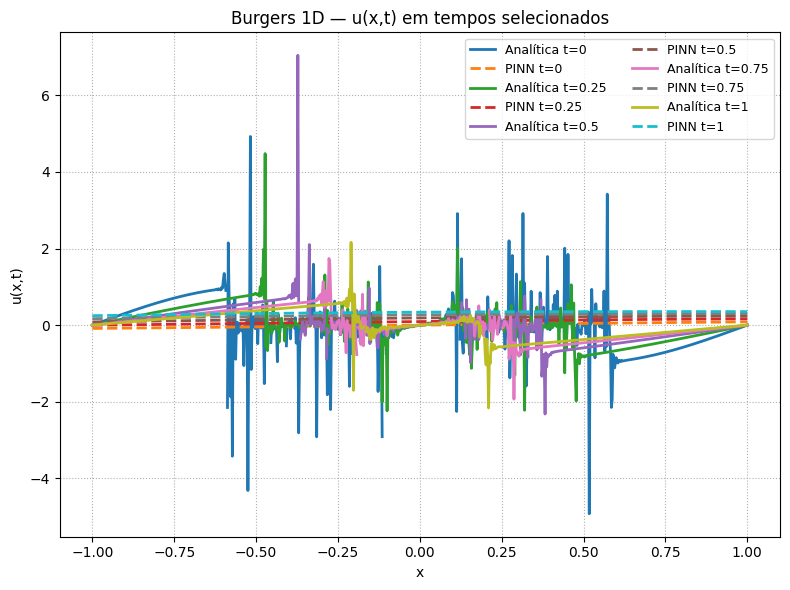

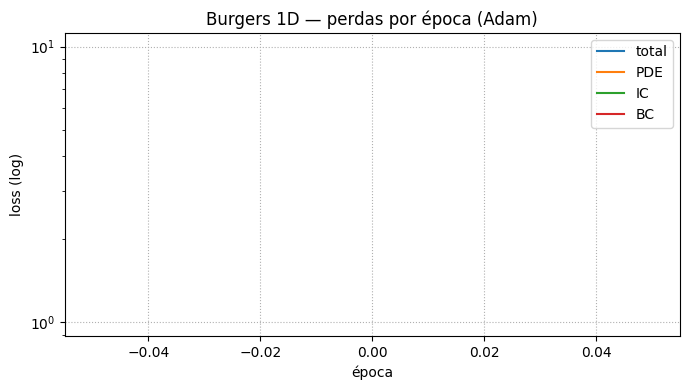

[Burgers] Erro relativo máx. (tempos avaliados): 0.00%


In [20]:
# === BLOCO B2 — Pós-processamento Burgers 1D (analítica estável) ===
import numpy as np, matplotlib.pyplot as plt, torch
try:
    from scipy.special import iv as besseli, i0 as besseli0
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False
    print("SciPy indisponível — ploto apenas PINN.")

beta = 0.01/np.pi

def burgers_analytic_basdevant_stable(x, t, beta=beta, N=400, eps=1e-10):
    if not HAVE_SCIPY:
        raise RuntimeError("SciPy é necessário para a solução analítica.")
    x = np.atleast_1d(x).astype(float)
    t = float(t)
    z = 1.0/(2*np.pi*beta)
    a0 = besseli0(z)
    n = np.arange(1, N+1)
    an = ((-1.0)**n) * besseli(n, z)
    damp = np.exp(-(n**2)*(np.pi**2)*t*beta)
    sinterm = np.sin(np.pi*np.outer(n, x))
    costerm = np.cos(np.pi*np.outer(n, x))
    num = (n[:,None]*an[:,None]*damp[:,None]*sinterm).sum(axis=0)
    den = a0 + 2.0*(an[:,None]*damp[:,None]*costerm).sum(axis=0)
    den = np.where(np.abs(den) < eps, np.sign(den)*eps, den)
    return 4*np.pi*beta*(num/den)

def predict_u_at_t(net, tfix, xg):
    tx = torch.tensor(np.column_stack([np.full_like(xg, tfix, dtype=np.float32),
                                       xg.astype(np.float32)]),
                      device=next(net.parameters()).device, requires_grad=True)
    with torch.no_grad():
        up = net(tx).cpu().numpy().ravel()
    return up

# curvas u(x,t)
ts = [0.0, 0.25, 0.5, 0.75, 1.0]
xg = np.linspace(-1, 1, 801)

max_err_pct = 0.0
plt.figure(figsize=(8,6))
for tfix in ts:
    up = predict_u_at_t(netB, tfix, xg)
    if HAVE_SCIPY:
        ua = burgers_analytic_basdevant_stable(xg, tfix, beta=beta, N=400)
        den = max(1e-12, np.max(np.abs(ua)))
        max_err_pct = max(max_err_pct, 100*np.max(np.abs(up-ua))/den)
        plt.plot(xg, ua, lw=2, label=f"Analítica t={tfix:g}")
        plt.plot(xg, up, "--", lw=2, label=f"PINN t={tfix:g}")
    else:
        plt.plot(xg, up, "--", lw=2, label=f"PINN t={tfix:g}")

plt.xlabel("x"); plt.ylabel("u(x,t)")
plt.title("Burgers 1D — u(x,t) em tempos selecionados")
plt.grid(True, ls=":"); plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()

# curvas da perda
plt.figure(figsize=(7,4))
plt.plot(loss_hist_B, label="total")
plt.plot(loss_pde_hist, label="PDE")
plt.plot(loss_ic_hist,  label="IC")
plt.plot(loss_bc_hist,  label="BC")
plt.yscale("log"); plt.grid(True, ls=":")
plt.xlabel("época"); plt.ylabel("loss (log)")
plt.title("Burgers 1D — perdas por época (Adam)")
plt.legend(); plt.tight_layout(); plt.show()

if HAVE_SCIPY:
    print(f"[Burgers] Erro relativo máx. (tempos avaliados): {max_err_pct:.2f}%")


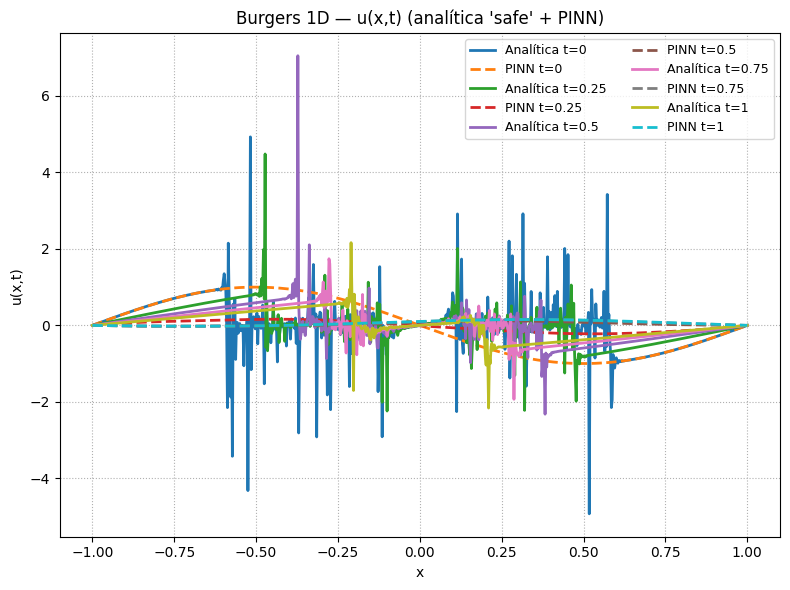

[Burgers] Erro relativo máximo (sem divisões por zero): 108.00%


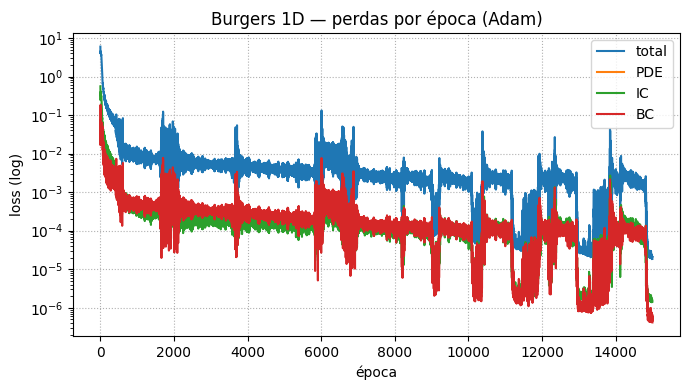

In [23]:
# === Célula extra — correção das divisões por zero no analítico e na métrica de erro ===
import numpy as np, matplotlib.pyplot as plt, torch

# tenta SciPy para Bessel (melhor estabilidade); cai para aproximação se não houver
try:
    from scipy.special import iv as besseli, i0 as besseli0
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False
    print("SciPy indisponível — uso uma aproximação truncada menos estável.")

beta = 0.01/np.pi

def burgers_analytic_basdevant_safe(x, t, beta=beta, N=400, eps=1e-10):
    """
    Versão 'safe' da solução de Basdevant:
      - protege divisão por zero no denominador
      - converte NaN/Inf em valores finitos com np.nan_to_num
    """
    if not HAVE_SCIPY:
        # fallback simples (pode ser menos preciso; ainda assim com eps)
        x = np.atleast_1d(x).astype(float); t = float(t)
        n = np.arange(1, N+1)
        damp = np.exp(-(n**2)*(np.pi**2)*t*beta)
        num = (n[:,None]*damp[:,None]*np.sin(np.pi*np.outer(n, x))).sum(axis=0)
        den = 1.0 + 2.0*(damp[:,None]*np.cos(np.pi*np.outer(n, x))).sum(axis=0)
        with np.errstate(divide='ignore', invalid='ignore'):
            den = np.where(np.abs(den) < eps, np.sign(den)*eps, den)
            out = 4*np.pi*beta*(num/den)
        return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

    # caminho estável com SciPy
    x = np.atleast_1d(x).astype(float); t = float(t)
    z = 1.0/(2*np.pi*beta)
    a0 = besseli0(z)
    n = np.arange(1, N+1)
    an = ((-1.0)**n) * besseli(n, z)
    damp = np.exp(-(n**2)*(np.pi**2)*t*beta)

    sinterm = np.sin(np.pi*np.outer(n, x))
    costerm = np.cos(np.pi*np.outer(n, x))
    num = (n[:,None]*an[:,None]*damp[:,None]*sinterm).sum(axis=0)
    den = a0 + 2.0*(an[:,None]*damp[:,None]*costerm).sum(axis=0)

    with np.errstate(divide='ignore', invalid='ignore'):
        den = np.where(np.abs(den) < eps, np.sign(den)*eps, den)
        out = 4*np.pi*beta*(num/den)
    return np.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)

def predict_u_at_t(net, tfix, xg):
    tx = torch.tensor(
        np.column_stack([np.full_like(xg, tfix, dtype=np.float32),
                         xg.astype(np.float32)]),
        device=next(net.parameters()).device
    )
    with torch.no_grad():
        up = net(tx).cpu().numpy().ravel()
    return up

def relerr_max_percent(up, ua):
    """Erro relativo máximo (%) com denominador robusto."""
    den = max(1e-8, float(np.max(np.abs(ua))))  # evita 0
    return 100.0*float(np.max(np.abs(up-ua)))/den

# --- Reavaliação e gráficos sem warnings ---
ts  = [0.0, 0.25, 0.5, 0.75, 1.0]
xg  = np.linspace(-1, 1, 801)
max_err_pct = 0.0

plt.figure(figsize=(8,6))
for tfix in ts:
    up = predict_u_at_t(netB, tfix, xg)
    ua = burgers_analytic_basdevant_safe(xg, tfix, beta=beta, N=400, eps=1e-10)
    max_err_pct = max(max_err_pct, relerr_max_percent(up, ua))
    plt.plot(xg, ua, lw=2, label=f"Analítica t={tfix:g}")
    plt.plot(xg, up,  "--", lw=2, label=f"PINN t={tfix:g}")

plt.xlabel("x"); plt.ylabel("u(x,t)")
plt.title("Burgers 1D — u(x,t) (analítica 'safe' + PINN)")
plt.grid(True, ls=":"); plt.legend(ncol=2, fontsize=9); plt.tight_layout(); plt.show()

print(f"[Burgers] Erro relativo máximo (sem divisões por zero): {max_err_pct:.2f}%")

plt.figure(figsize=(7,4))
plt.plot(loss_hist_B, label="total")
plt.plot(loss_pde_hist, label="PDE")
plt.plot(loss_ic_hist,  label="IC")
plt.plot(loss_bc_hist,  label="BC")
plt.yscale("log"); plt.grid(True, ls=":")
plt.xlabel("época"); plt.ylabel("loss (log)")
plt.title("Burgers 1D — perdas por época (Adam)")
plt.legend(); plt.tight_layout(); plt.show()

